In [2]:
#importing necessary libaries 
#I have tried to harvest all the packages we used
#but maybe there are some missing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced



from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation, Flatten
from keras.models import Sequential
from sklearn import preprocessing
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim





# I use Word2Vec object created from the text review to train CNN

In [3]:
df=pd.read_csv("supply_chain_text_prep_06_06.csv", sep=',')
df.head()

,Product Name,Brand Name,Price,Stars,Text,Review Votes,AverageRating,ReviewsNumber,Sentiment,Review length,Word count,emoji
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",SAMSUNG,199.99,5,feel lucky found used phone us used hard phone...,1.0,3.702703,37,Positive,374,72,[]
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",SAMSUNG,199.99,4,nice phone nice grade pantach revue clean set ...,0.0,3.702703,37,Positive,214,40,[]
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",SAMSUNG,199.99,5,pleased,0.0,3.702703,37,Positive,12,2,[]
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",SAMSUNG,199.99,4,works good goes slow sometimes good phone love,0.0,3.702703,37,Positive,76,17,[]
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",SAMSUNG,199.99,4,great phone replace lost phone thing volume bu...,0.0,3.702703,37,Positive,223,43,[]


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326799 entries, 0 to 326798
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Product Name   326799 non-null  object 
 1   Brand Name     326799 non-null  object 
 2   Price          321825 non-null  float64
 3   Stars          326799 non-null  int64  
 4   Text           326054 non-null  object 
 5   Review Votes   326799 non-null  float64
 6   AverageRating  326799 non-null  float64
 7   ReviewsNumber  326799 non-null  int64  
 8   Sentiment      326799 non-null  object 
 9   Review length  326799 non-null  int64  
 10  Word count     326799 non-null  int64  
 11  emoji          326799 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 29.9+ MB


In [5]:
#we have some NaNs in Text
df.dropna(subset = ['Text'], inplace=True)


#and I removed them

In [6]:
#Word2Vec objects and CNN
import gensim
review_text = df['Text'].apply(gensim.utils.simple_preprocess)
model = gensim.models.Word2Vec(window=10, 
                               min_count=5, 
                               workers=4, 
                               alpha=0.01,
                               negative=20,
                               sample=0.0001)
# min_count :int - Ignores all words with total absolute frequency lower than this - (2, 100)
# window: = int - The maximum distance between the current and predicted word within a sentence
# alpha = float - The initial learning rate - (0.01, 0.05)
#negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" 
     #should be drown. If set to 0, no negative sampling is used. 
#workers = int - Use these many worker threads to train the model (=faster training with multicore machines)
#sample = float - The threshold for configuring which higher-frequency words 
           #are randomly downsampled. Highly influencial. - (0, 1e-5)

review_text = df['Text'].apply(gensim.utils.simple_preprocess)
model.build_vocab(review_text, progress_per=10000)
model.train(review_text, total_examples=model.corpus_count, epochs=50, report_delay=1)

(185020696, 348562950)

In [7]:
print(model)

Word2Vec<vocab=26139, vector_size=100, alpha=0.01>


In [8]:
token = Tokenizer(25718)
token.fit_on_texts(df['Text'])
text = token.texts_to_sequences(df['Text'])

print(text[:2])


[[208, 1772, 180, 34, 1, 130, 34, 201, 1, 505, 345, 767, 534, 5, 411, 468, 92, 5, 413, 1037, 1253, 224, 60, 66, 289, 2, 2, 210, 59, 14, 1450, 4166, 123, 34, 1060, 58, 59, 344, 11, 2, 2], [31, 1, 31, 3056, 717, 178, 71, 178, 74, 44, 1, 514, 374, 51, 96, 1668, 1228, 770, 3, 1]]


In [9]:
df.Sentiment = df.Sentiment.replace(['Positive','Negative','Neutral'],[2,0,1])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(text, df.Sentiment, test_size=0.2, stratify=df.Sentiment)

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')
vocab_size = len(token.word_index) + 1

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in token.word_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]


In [12]:
y_train.shape

(260843, 3)

In [15]:
# Define the CNN model
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPool1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPool1D(5))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#the number of epoch was higher, but I reduced to optimal (Unfortunately I did not install early stopp callback)

training_history_1=model.fit(X_train, y_train, epochs=15, batch_size=50, validation_data=(X_test, y_test))

Epoch 1/15
5217/5217 [==============================] - 204s 39ms/step - loss: 0.4073 - accuracy: 0.8545 - val_loss: 0.3701 - val_accuracy: 0.8668
Epoch 2/15
5217/5217 [==============================] - 202s 39ms/step - loss: 0.3409 - accuracy: 0.8778 - val_loss: 0.3383 - val_accuracy: 0.8797
Epoch 3/15
5217/5217 [==============================] - 214s 41ms/step - loss: 0.2942 - accuracy: 0.8959 - val_loss: 0.3120 - val_accuracy: 0.8917
Epoch 4/15
5217/5217 [==============================] - 209s 40ms/step - loss: 0.2546 - accuracy: 0.9123 - val_loss: 0.3025 - val_accuracy: 0.8983
Epoch 5/15
5217/5217 [==============================] - 203s 39ms/step - loss: 0.2230 - accuracy: 0.9245 - val_loss: 0.3104 - val_accuracy: 0.8985
Epoch 6/15
5217/5217 [==============================] - 204s 39ms/step - loss: 0.1981 - accuracy: 0.9331 - val_loss: 0.3011 - val_accuracy: 0.9070
Epoch 7/15
5217/5217 [==============================] - 220s 42ms/step - loss: 0.1776 - accuracy: 0.9409 - val_loss: 0

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          11118900  
                                                                 
 conv1d_6 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 19, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 15, 128)           82048     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 3, 128)           

In [17]:
train_acc = training_history_1.history['accuracy']
val_acc = training_history_1.history['val_accuracy']
train_loss=training_history_1.history['loss']
val_loss = training_history_1.history['val_loss']

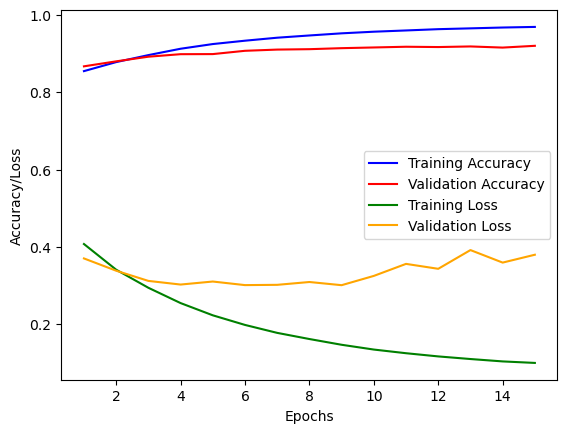

In [19]:

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 16, 1),
         training_history_1.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , 16, 1),
         training_history_1.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

plt.plot(np.arange(1 , 16, 1),
        training_history_1.history['loss'], 
        label = 'Training Loss',
         color = 'green')
plt.plot(np.arange(1 , 16, 1),
         training_history_1.history['val_loss'], 
         label = 'Validation Loss',
         color = 'orange')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [22]:
from sklearn.metrics import classification_report
test_pred = model.predict(X_test)

test_pred_class = test_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis=1)

print("Classifiation report of CNN\n", classification_report(y_test_class, test_pred_class))
print("Confusion matrix of CNN:\n")

pd.crosstab(y_test_class,test_pred_class, rownames=['Real sentiment'], colnames=['Predicted sentiment'])

2038/2038 [==============================] - 6s 3ms/step
Classiciation report of CNN
               precision    recall  f1-score   support

           0       0.88      0.90      0.89     15653
           1       0.70      0.58      0.63      5012
           2       0.95      0.96      0.96     44546

    accuracy                           0.92     65211
   macro avg       0.85      0.81      0.83     65211
weighted avg       0.92      0.92      0.92     65211

Confusion matrix of CNN:



Predicted sentiment,0,1,2
Real sentiment,,,
0,14157,521,975
1,972,2883,1157
2,874,724,42948


## with Tanh activation function

In [23]:
# Define the CNN model
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length))
model.add(Conv1D(128, 5, activation='tanh'))
model.add(MaxPool1D(5))
model.add(Conv1D(128, 5, activation='tanh'))
model.add(MaxPool1D(5))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#the number of epoch was higher, but I reduced to optimal (Unfortunately I did not install early stopp callback)

training_history_2=model.fit(X_train, y_train, epochs=15, batch_size=50, validation_data=(X_test, y_test))

Epoch 1/15
5217/5217 [==============================] - 210s 40ms/step - loss: 0.4095 - accuracy: 0.8529 - val_loss: 0.3728 - val_accuracy: 0.8669
Epoch 2/15
5217/5217 [==============================] - 204s 39ms/step - loss: 0.3507 - accuracy: 0.8748 - val_loss: 0.3547 - val_accuracy: 0.8726
Epoch 3/15
5217/5217 [==============================] - 198s 38ms/step - loss: 0.3203 - accuracy: 0.8861 - val_loss: 0.3384 - val_accuracy: 0.8835
Epoch 4/15
5217/5217 [==============================] - 195s 37ms/step - loss: 0.2974 - accuracy: 0.8957 - val_loss: 0.3276 - val_accuracy: 0.8861
Epoch 5/15
5217/5217 [==============================] - 200s 38ms/step - loss: 0.2775 - accuracy: 0.9041 - val_loss: 0.3217 - val_accuracy: 0.8906
Epoch 6/15
5217/5217 [==============================] - 204s 39ms/step - loss: 0.2627 - accuracy: 0.9099 - val_loss: 0.3191 - val_accuracy: 0.8944
Epoch 7/15
5217/5217 [==============================] - 205s 39ms/step - loss: 0.2488 - accuracy: 0.9157 - val_loss: 0

In [25]:
train_acc = training_history_2.history['accuracy']
val_acc = training_history_2.history['val_accuracy']
train_loss=training_history_2.history['loss']
val_loss = training_history_2.history['val_loss']

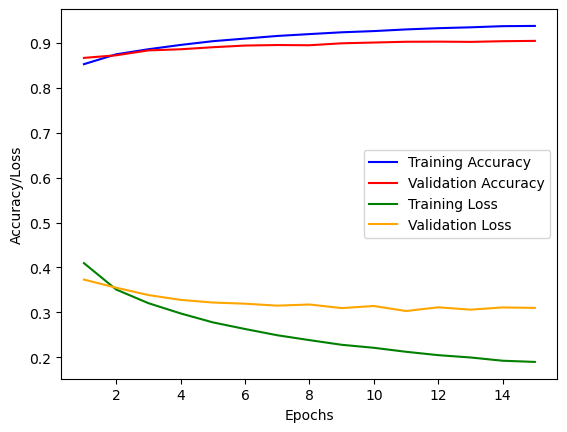

In [27]:

plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')


plt.plot(np.arange(1 , 16, 1),
         training_history_2.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')


plt.plot(np.arange(1 , 16, 1),
         training_history_2.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

plt.plot(np.arange(1 , 16, 1),
        training_history_2.history['loss'], 
        label = 'Training Loss',
         color = 'green')
plt.plot(np.arange(1 , 16, 1),
         training_history_2.history['val_loss'], 
         label = 'Validation Loss',
         color = 'orange')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()b

In [28]:
from sklearn.metrics import classification_report
test_pred = model.predict(X_test)

test_pred_class = test_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis=1)

print("Classifiation report of CNN\n", classification_report(y_test_class, test_pred_class))
print("Confusion matrix of CNN:\n")

pd.crosstab(y_test_class,test_pred_class, rownames=['Real sentiment'], colnames=['Predicted sentiment'])

2038/2038 [==============================] - 7s 4ms/step
Classifiation report of CNN
               precision    recall  f1-score   support

           0       0.87      0.89      0.88     15653
           1       0.60      0.50      0.55      5012
           2       0.95      0.96      0.95     44546

    accuracy                           0.90     65211
   macro avg       0.80      0.78      0.79     65211
weighted avg       0.90      0.90      0.90     65211

Confusion matrix of CNN:



Predicted sentiment,0,1,2
Real sentiment,,,
0,13869,730,1054
1,1156,2516,1340
2,973,957,42616


# Binary classification sentiment analysis

In [33]:
df.head()

,Product Name,Brand Name,Price,Stars,Text,Review Votes,AverageRating,ReviewsNumber,Sentiment,Review length,Word count,emoji
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",SAMSUNG,199.99,5,feel lucky found used phone us used hard phone...,1.0,3.702703,37,Positive,374,72,[]
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",SAMSUNG,199.99,4,nice phone nice grade pantach revue clean set ...,0.0,3.702703,37,Positive,214,40,[]
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",SAMSUNG,199.99,5,pleased,0.0,3.702703,37,Positive,12,2,[]
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",SAMSUNG,199.99,4,works good goes slow sometimes good phone love,0.0,3.702703,37,Positive,76,17,[]
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",SAMSUNG,199.99,4,great phone replace lost phone thing volume bu...,0.0,3.702703,37,Positive,223,43,[]


In [36]:
#CNN for binary classification


df_binary=df.loc[df.Sentiment!='Neutral']

df_binary.to_csv('Supply_chain_binary_10_06.csv')


In [37]:
df=pd.read_csv('Supply_chain_binary_10_06.csv')

In [39]:
model_binary= gensim.models.Word2Vec(window=10, 
                               min_count=5, 
                               workers=4, 
                               alpha=0.01,
                               negative=20,
                               sample=0.0001)
review_text = df['Text'].apply(gensim.utils.simple_preprocess)
model_binary.build_vocab(review_text, progress_per=10000)
model_binary.train(review_text, total_examples=model_binary.corpus_count, epochs=50, report_delay=1)

print(model_binary)

Word2Vec<vocab=24596, vector_size=100, alpha=0.01>


In [44]:

token = Tokenizer(24596)
token.fit_on_texts(df['Text'])
text = token.texts_to_sequences(df['Text'])

print(text[:2])


[[209, 1765, 181, 34, 1, 128, 34, 220, 1, 503, 355, 747, 524, 5, 392, 477, 93, 5, 412, 1069, 1282, 212, 62, 65, 286, 2, 2, 184, 56, 13, 1455, 4088, 121, 34, 1068, 53, 56, 304, 12, 2, 2], [31, 1, 31, 3178, 701, 175, 67, 175, 73, 43, 1, 483, 397, 47, 96, 1641, 1201, 767, 3, 1]]


In [70]:

X_train, X_test, y_train, y_test = train_test_split(text, df.Sentiment, test_size=0.2, stratify=df.Sentiment)


y_train.shape

(240796,)

In [71]:
y_test=y_test.str.get_dummies(sep='*')

In [72]:
y_train=y_train.str.get_dummies(sep='*')

In [73]:
y_train.shape

(240796, 2)

In [74]:


max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')
vocab_size = len(token.word_index) + 1

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in token.word_index.items():
    if word in model_binary.wv:
        embedding_matrix[i] = model_binary.wv[word]

In [75]:


model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))

model.add(MaxPool1D(5))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5, activation='relu'))

model.add(MaxPool1D(5))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
training_history_3=model.fit(X_train, y_train, epochs=5, batch_size=250, validation_data=(X_test, y_test))

Epoch 1/5
964/964 [==============================] - 77s 79ms/step - loss: 0.2106 - accuracy: 0.9188 - val_loss: 0.1673 - val_accuracy: 0.9368
Epoch 2/5
964/964 [==============================] - 69s 72ms/step - loss: 0.1578 - accuracy: 0.9416 - val_loss: 0.1485 - val_accuracy: 0.9468
Epoch 3/5
964/964 [==============================] - 70s 72ms/step - loss: 0.1340 - accuracy: 0.9519 - val_loss: 0.1336 - val_accuracy: 0.9523
Epoch 4/5
964/964 [==============================] - 70s 73ms/step - loss: 0.1148 - accuracy: 0.9600 - val_loss: 0.1445 - val_accuracy: 0.9499
Epoch 5/5
964/964 [==============================] - 69s 72ms/step - loss: 0.1005 - accuracy: 0.9658 - val_loss: 0.1205 - val_accuracy: 0.9593


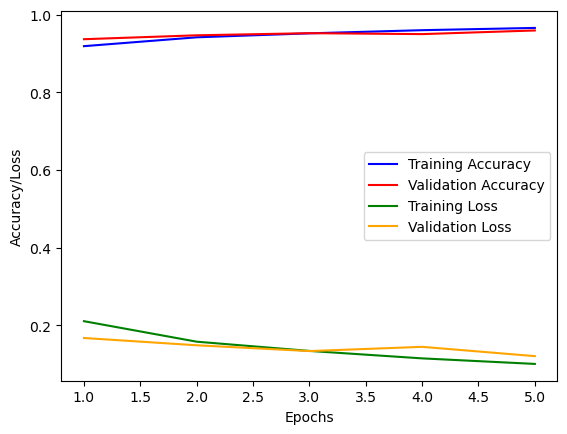

In [76]:
train_acc = training_history_3.history['accuracy']
val_acc = training_history_3.history['val_accuracy']
train_loss=training_history_3.history['loss']
val_loss = training_history_3.history['val_loss']


# Label the axis
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')

# accuracy for training set
plt.plot(np.arange(1 , 6, 1),
         training_history_3.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# accuracy for test set
plt.plot(np.arange(1 ,6, 1),
         training_history_3.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

plt.plot(np.arange(1 ,6, 1),
        training_history_3.history['loss'], 
        label = 'Training Loss',
         color = 'green')
plt.plot(np.arange(1 ,6, 1),
         training_history_3.history['val_loss'], 
         label = 'Validation Loss',
         color = 'orange')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [85]:

test_pred = model.predict(X_test)

#test_pred_class = test_pred.argmax(axis = 1)
#y_test_class = y_test().argmax(axis=1)

print("Classifiation report of CNN:\n", metrics.classification_report(np.argmax(y_test,axis=1), np.argmax(test_pred, axis=1)))
print("Confusion matrix of CNN:\n")

pd.crosstab(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), rownames=['Real sentiment'], colnames=['Predicted sentiment'])


1882/1882 [==============================] - 5s 3ms/step
Classifiation report of CNN:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     15653
           1       0.97      0.97      0.97     44546

    accuracy                           0.96     60199
   macro avg       0.95      0.95      0.95     60199
weighted avg       0.96      0.96      0.96     60199

Confusion matrix of CNN:



Predicted sentiment,0,1
Real sentiment,,
0,14376,1277
1,1176,43370


In [86]:
import joblib

# save
joblib.dump(model, "cnn_binary.pkl") 

['cnn_binary.pkl']